In [1]:
# imports
import numpy as np
import pandas as pd
import json
import requests
import os
import sys
#from operator import itemgetter
from datetime import datetime

# set up file paths and other data globals

import config, modify

sys.path.append(config.CURRENT_DIR_STR)
sys.path.append(config.COVID_PACKAGE_STR)
sys.path.append(config.UPDATE_FILE_STR)

# local imports

from covid_package.data_funcs.store_data import read_json_data, convert_owid_data, print_update_record
from covid_package.data_funcs.update_data import check_refresh_data

from covid_package.libs.valid_keys import fetch_l0_keys, fetch_l1_keys, fetch_l2_keys
from covid_package.libs.aggregate_data import fetch_latest_data_date, fetch_date_list
from covid_package.libs.country_list import fetch_countries

from covid_package.api.get_country_records import get_country_records
from covid_package.api.get_country_data import get_l0_data, get_l1_data, get_l2_iso_data, get_l2_date_data
from covid_package.api.get_case_death_data import get_case_death_stdev

#from covid_package.plots.plot_results import line_plot

from covid_package.plots.plot_results import subplot_share_axis
print("Imports complete")

Imports complete


In [2]:
# update data

if check_refresh_data():
    # read the updated(?) data file from the data dir
    data = read_json_data(config.DATA_FILE_STR)
    # convert the OWID_ keys
    data = convert_owid_data(data)
    # repopulate the keys
    key_list = fetch_l0_keys(data)
    # need this?
    #country_list = fetch_countries(data)
    # get the date of the newest data records in owid-covid-data.json
    print("Latest data is:", fetch_latest_data_date(data, key_list))
    print("Last update =", config.UPDATE_DATETIME_STR)

Checking that data is up to date
Data file up to date
Latest data is: 2021-05-10
Last update = 2021-05-10T13:28:0Z


In [3]:
#[print(k) for k in key_list]

# get the data for a single country
#print(get_l0_data(data, 'CYN'))

# get the level 1 data for all countries
#print(get_l1_data(data, key_list, ['location']))

# list of valid level 1 keys
#print(fetch_l1_keys(data, key_list))

# list of valid level 2 keys
#print(fetch_l2_keys(data, key_list))

# for each country, get record numbers and data dates
#print(get_country_records(data, key_list))

# get an exhaustive list of dates in the data
date_list = fetch_date_list(data, key_list)

# define the list of required resources
res = ['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million']

# returns a dict with key = date, values = dict of isos
# the value of each iso key is a list of the required resources
country_date_data = get_l2_date_data(data, key_list, date_list, res)

print("Country_date_data complete...")
#print(country_date_data['2021-05-04'])

Country_date_data complete...


In [4]:
# cycle through each day's collections of new cases and new deaths

# truncate today's (zulu time) data, as it will almost certainly be incomplete
this_date = datetime.utcnow().strftime("%Y-%m-%d")

if this_date in country_date_data.keys():
    country_date_data.pop(this_date)
print("UTC 0 date is:", this_date)

date_dict = dict()
for day in country_date_data:

    #print(country_date_data[day])

    # calculate the wrl_new_ cases/deaths _per_million
    if country_date_data[day]['WRL'][0]:
        wrl_new_cases_pm = country_date_data[day]['WRL'][0]
    else:
        wrl_new_cases_pm = 0
    
    if country_date_data[day]['WRL'][1]:
        wrl_new_deaths_pm = country_date_data[day]['WRL'][1]
    else:
        wrl_new_deaths_pm = 0

    # pop the wrl vals out of the structure
    # so they don't screw up the stdev calculation
    country_date_data[day].pop('WRL')

    # calculate the std dev for the day
    mean_stdev = get_case_death_stdev(country_date_data[day])

    # populate the date dict for this day
    date_dict[day] = {
        "wrl_new_cases_pm": wrl_new_cases_pm,
        "wrl_new_deaths_pm": wrl_new_deaths_pm,
        "stdev_new_cases_pm": mean_stdev[0],
        "stdev_new_deaths_pm": mean_stdev[1],
        "country_vals": country_date_data[day]
    }


print("date_dict compiled")
#test_date = '2021-05-04'
#print("date_dict for {}: {}".format(test_date, date_dict[test_date]))

UTC 0 date is: 2021-05-10
date_dict compiled


In [11]:
# re-juggle the data for the chart

# the country being analyzed
y_axis_values = 'SYC'

y_axis_label = data[y_axis_values]['location']

# declare the axis vars
x_axis = []
yw1_axis = []
y1_axis = []
yw2_axis = []
y2_axis = []

min_x = '2020-01-01'
max_x = '2020-01-01'
min_y1 = 0
max_y1 = 0
min_y2 = 0
max_y2 = 0

# load up the axis data lists
for key, val in date_dict.items():

    #print(key, val['country_vals'][y1_axis_values])
    """
    # find the max date
    if key > max_x:
        max_x = key

    # for countries below the global mean, detect the max_y
    if val["wrl_new_cases_pm"] > max_y1:
        max_y1 = val["wrl_new_cases_pm"]

    if val["wrl_new_deaths_pm"] > max_y2:
        max_y2 = val["wrl_new_deaths_pm"]    

    # for countries above the global mean, detect the max_y    
    if val['country_vals'][y_axis_values][0] > max_y1:
        max_y1 = val['country_vals'][y_axis_values][0]

    if val['country_vals'][y_axis_values][1] > max_y2:
        max_y2 = val['country_vals'][y_axis_values][1]
    """
    # assemble the chart data lists
    # list of dates
    x_axis.append(datetime.strptime(key, "%Y-%m-%d"))
    # lists of cases
    yw1_axis.append(val["wrl_new_cases_pm"])
    y1_axis.append(val['country_vals'][y_axis_values][0])
    # lists of deaths
    yw2_axis.append(val["wrl_new_deaths_pm"])
    y2_axis.append(val['country_vals'][y_axis_values][1])

#print("x_axis =", x_axis)
#print("yw1_axis =", yw1_axis)
#print("y1_axis =", y1_axis)   
#print("yw2_axis =", yw2_axis)   
#print("y2_axis =", y2_axis)    
print("Data juggling complete")    

Data juggling complete


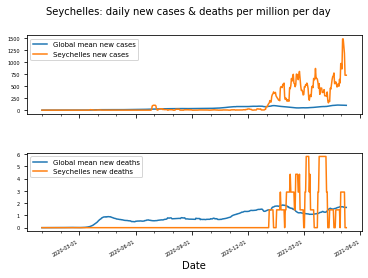

In [12]:
# package up the matplotlib data

# manage the labels
chart_title_str = "{}: daily new cases & deaths per million per day".format(y_axis_label)
y1_axis_label_str = "New cases"
y2_axis_label_str = "New deaths"

yw1_axis_legend_str = "Global mean new cases"
y1_axis_legend_str = "{} new cases".format(y_axis_label)

yw2_axis_legend_str = "Global mean new deaths"
y2_axis_legend_str = "{} new deaths".format(y_axis_label)
    
# create the labels
labels_obj = {}
labels_obj['chart_title'] = chart_title_str

labels_obj['x_axis_label'] = "Date"
labels_obj['y1_axis_label'] = y1_axis_label_str
labels_obj['y2_axis_label'] = y2_axis_label_str

labels_obj['legend_1a'] = yw1_axis_legend_str
labels_obj['legend_1b'] = y1_axis_legend_str
labels_obj['legend_2a'] = yw2_axis_legend_str
labels_obj['legend_2b'] = y2_axis_legend_str

# package the results
results_obj = {}

results_obj['x_axis'] = x_axis
results_obj['yw1_axis'] = yw1_axis
results_obj['y1_axis'] = y1_axis
results_obj['yw2_axis'] = yw2_axis
results_obj['y2_axis'] = y2_axis

# package the params
params_obj = {}

params_obj['axis_settings'] = [min_x, max_x, min_y1, max_y1, min_y2, max_y2]

# call matplotlib driver function
subplot_share_axis(labels_obj, results_obj, params_obj)
